# Analysis of ArXiv metadata
### YSJ student no 199108682, May 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import urllib.request as url_request
import networkx as nx

# set global parameters for chart formatting
plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["font.size"] = 15

### Preparing the data for use

Download the ArXiv metadata as a zip from https://www.kaggle.com/datasets/Cornell-University/arxiv.<br>
Unzip it into C:/users/public/downloads/

In [65]:
arxiv_metadata = []

# Open the source file and read contents into a list of JSON records
with open("C:/users/public/downloads/arxiv-metadata-oai-snapshot.json", "r") as f:
    
    for line in f: 
        arxiv_metadata.append(json.loads(line))

In [104]:
# inspect a sample record
arxiv_metadata[2068279]

{'id': 'supr-con/9609004',
 'submitter': 'Masanori Ichioka',
 'authors': 'Naoki Enomoto, Masanori Ichioka and Kazushige Machida (Okayama Univ.)',
 'title': 'Ginzburg Landau theory for d-wave pairing and fourfold symmetric vortex\n  core structure',
 'comments': '12 pages including 8 eps figs, LaTeX with jpsj.sty & epsfig',
 'journal-ref': 'J. Phys. Soc. Jpn. 66, 204 (1997).',
 'doi': '10.1143/JPSJ.66.204',
 'report-no': None,
 'categories': 'supr-con cond-mat.supr-con',
 'license': None,
 'abstract': "  The Ginzburg Landau theory for d_{x^2-y^2}-wave superconductors is\nconstructed, by starting from the Gor'kov equation with including correction\nterms up to the next order of ln(T_c/T). Some of the non-local correction terms\nare found to break the cylindrical symmetry and lead to the fourfold symmetric\ncore structure, reflecting the internal degree of freedom in the pair\npotential. Using this extended Ginzburg Landau theory, we investigate the\nfourfold symmetric structure of the pa

In [61]:
def clean_field(text):
    """Strips newlines and escaped quote marks out of text."""
    
    if (text is None) or (text == ""):
        return None
    
    else:
        re_newlines = re.compile(r"\\n|\\r|\n|\r", re.IGNORECASE)
        return '"' + re_newlines.sub(" ", text).replace("\"", "\'") + '"'


# open a new file into which we can copy the 5 relevant fields from the metadata
with open(file="metadata.csv", mode="w", encoding="utf-8") as f:
    
    for article in arxiv_metadata:
        # perform some trivial data cleaning on each of the fields 
        article_id = clean_field(article["id"])
        title = clean_field(article["title"])
        comments = clean_field(article["comments"])
        journal = clean_field(article["journal-ref"])
        categories = clean_field(article["categories"])
        csv_fields = [article_id, title, comments, journal, categories]
        
        # write the record to the csv, if it was not blank in any of the relevant fields
        if not ((None in csv_fields) or ("COVID" in article["title"].upper())):
            f.write(", ".join(csv_fields) + ",\n")

arxiv_metadata = None

In [62]:
# read the metadata csv in to a dataframe for ease of further processing
df = pd.read_csv("metadata.csv", names=["ID", "Title", "Comments", "Journal", "Categories"],
                 quotechar='"', sep=",", header=None, index_col=False, skipinitialspace=True)

df.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,Title,Comments,Journal,Categories
0,704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph
1,704.0007,Polymer Quantum Mechanics and its Continuum Limit,"16 pages, no figures. Typos corrected to match...","Phys.Rev.D76:044016,2007",gr-qc
2,704.0008,Numerical solution of shock and ramp compressi...,Minor corrections,"Journal of Applied Physics, vol 104, 073536 (2...",cond-mat.mtrl-sci
3,704.0015,Fermionic superstring loop amplitudes in the p...,22 pages; signs and coefficients adjusted for ...,"JHEP 0705:034,2007",hep-th
4,704.0016,Lifetime of doubly charmed baryons,"17 pages, 3 figures and 1 table","Commun.Theor.Phys.49:993-1000,2008",hep-ph


In [105]:
print("Unique entries in Journal: " + str(len(df.Journal.unique())) + 
      " out of " + str(len(df)) + " records (" + 
      str(100 * len(df.Journal.unique()) / len(df)) + "%).")

Unique entries in Journal: 647581 out of 651502 records (99.3981599442519%).


### Augment the data with some derived columns

In [106]:
nltk.download("stopwords")
stops = set(stopwords.words("english"))
print(stops)

{'them', "isn't", 'haven', 'yourself', "you're", 'itself', 'this', 'my', 'theirs', 'until', "needn't", 'all', 'did', "won't", 'our', 'then', 'too', 'should', 'him', 'a', 'further', 'own', 'off', 'his', 'here', "you've", 'be', "wasn't", 'am', 'mustn', 'about', 'for', "that'll", "hadn't", 'under', 'between', 'themselves', 'that', 'needn', 'which', 'below', 'having', 'while', 'from', 'who', 'these', 'doing', 'was', "mustn't", 'an', 'and', 'not', 'any', 'myself', 'what', 'have', 'd', 'shan', 'wasn', 'ours', 'doesn', 'were', 'there', 'don', 'very', 'just', 'as', 'weren', 'by', 'now', 'those', 'over', 'he', 'other', 'isn', "haven't", 're', 'few', 'mightn', 'more', "couldn't", "she's", 'i', 'yourselves', 'they', 'when', 'on', 'in', 'its', 'down', 'or', 'such', 'it', 'being', 'out', 'won', 'will', 'has', 'himself', 'whom', 'been', 'of', "wouldn't", 'had', 'after', 'so', 'most', "doesn't", "weren't", 'shouldn', 'hers', 'does', "don't", 'didn', 'your', 'll', 'm', "shan't", 'hadn', "aren't", 't',

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paper\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
def tokenize_and_clean_title(phrase):
    word_list = []    
    re_punctuation = re.compile(r"[^\w\s]|\d")
    
    for w in word_tokenize(phrase):
        word = re_punctuation.sub("", w).lower()
        
        if (word not in stops) and (len(word) > 1):
            word_list.append(word)
            
    return word_list

# test it...
print(tokenize_and_clean_title("Power Spectra to 11% Accuracy between Dynamical Dark Energy Cosmologies"))  

['power', 'spectra', 'accuracy', 'dynamical', 'dark', 'energy', 'cosmologies']


To decode cagetories, see https://arxiv.org/category_taxonomy

In [108]:
def split_categories(cat_codes):
    re_spaces = re.compile(r"[\s]")
    
    if (cat_codes == "") or (not isinstance(cat_codes, str)):
        return []
    
    else:
        return re_spaces.split(cat_codes)

# test it...
print(split_categories("physics.optics physics.comp-ph"))

['physics.optics', 'physics.comp-ph']


To decode journal abbreviations, see https://jabbr.mannlib.cornell.edu/

In [120]:
def get_journal_root(journal_ref):    
    # drop all punctuation apart from dots and dashes
    re_punctuation = re.compile(r"[^\w\s\.\-]")    
    j_ref_name = re_punctuation.sub("", journal_ref)
    
    # guess where the journal name begins and ignore anything before that
    #re_alpha_start = re.compile(r"\s(?=[a-zA-Z])|^(?=[a-zA-Z])")
    re_alpha_start = re.compile(r"(?=[a-zA-Z])")
    j_ref_name = re_alpha_start.split(j_ref_name, maxsplit=1)[-1]
    
    # guess where the issue number begins, and ignore anything after that
    re_digits = re.compile(r"\s*\d")
    j_ref_name = re_digits.split(j_ref_name, maxsplit=1)[0]
    
    # replace '. ' with '.'
    re_dot_space = re.compile(r"\. ")
    j_ref_name = re_dot_space.sub(".", j_ref_name)
    
    # strip away any leading 'the'
    re_the = re.compile(r"^the\s", re.IGNORECASE)
    j_ref_name = re_the.sub("", j_ref_name)
    
    return j_ref_name.lower()


def decode_journal_ref(journal_ref):
    """ Looks up journal-ref in Cornell's JABBR database.
    Retrurns the result if there was a match, and just echoes the original 
    journal ref if no match was found.
    """
    
    jabbr_site_url = "http://jabbr.mannlib.cornell.edu/json?q="
    # replace spaces with underscores, so we can include text in an http request
    re_spaces = re.compile(r"[\s]")
    j_ref_no_spaces = re_spaces.sub("_", journal_ref)

    try:
        # submit request to JABBR search engine
        with url_request.urlopen(jabbr_site_url + j_ref_no_spaces + "&max=1") as url:
            data = json.loads(url.read().decode())

            # there may actually be many different matches; keep the #1 hit
            if len(data["matches"]) > 0:
                journal_name = data["matches"][0]["title"]

            else:
                journal_name = journal_ref
        
    except:
        journal_name = journal_ref
    
    return journal_name

# test it...           
print(get_journal_root("J. Phys. Soc. Jpn. 66, 204 (1997)."))

j.phys.soc.jpn.


In [119]:
print(decode_journal_ref(get_journal_root("J. Phys. Soc. Jpn. 66, 204 (1997).")))

Journal of the Physical Society of Japan


In [110]:
df["title_words"] = [tokenize_and_clean_title(t) for t in df.Title]
# df["journal_name"] = [decode_journal_ref(j) for j in df.Journal]
df["journal_ref_root"] = [get_journal_root(j) for j in df.Journal]
df["category_list"] = [split_categories(c) for c in df.Categories]
df["category_count"] = [len(c) for c in df.category_list]
df["tword_count"] = [len(t) for t in df.title_words]

In [112]:
df.tail(5)

,ID,Title,Comments,Journal,Categories,title_words,journal_ref_root,category_list,category_count,tword_count
651497,supr-con/9608001,Topology and Phase Transitions in the Little-P...,"Latex, 26 pages, 5 figs upon request",SIAM J Appl Math {\bf 58} (1998) 103--121,supr-con cond-mat.supr-con quant-ph,"[topology, phase, transitions, littleparks, ex...",siam j appl math bf,"[supr-con, cond-mat.supr-con, quant-ph]",3,5
651498,supr-con/9608003,Extended bound states and resonances of two fe...,"21 pages, RevTeX, 4 Postscript figures, arithm...","Phys. Rev. B 55, 6035 (1997)",supr-con cond-mat.supr-con,"[extended, bound, states, resonances, two, fer...",phys.rev.b,"[supr-con, cond-mat.supr-con]",2,8
651499,supr-con/9608004,Ginzburg-Landau-Gor'kov Theory of Magnetic osc...,"39 pages, 8 figures. This is a replacement of ...",PHYS REV B 56: (2) 809-825 JUL 1 1997,supr-con cond-mat.supr-con,"[ginzburglandaugorkov, theory, magnetic, oscil...",phys rev b,"[supr-con, cond-mat.supr-con]",2,7
651500,supr-con/9608005,Evidence for Quasiparticle Decay in Photoemiss...,"4 pages of ReVTeX, 3 eps figures","Phys. Rev. Lett. 79, 1726 (1997)",supr-con cond-mat.supr-con,"[evidence, quasiparticle, decay, photoemission...",phys.rev.lett.,"[supr-con, cond-mat.supr-con]",2,6
651501,supr-con/9609004,Ginzburg Landau theory for d-wave pairing and ...,"12 pages including 8 eps figs, LaTeX with jpsj...","J. Phys. Soc. Jpn. 66, 204 (1997).",supr-con cond-mat.supr-con,"[ginzburg, landau, theory, dwave, pairing, fou...",j.phys.soc.jpn.,"[supr-con, cond-mat.supr-con]",2,10


### Inspect the journals data for sensibleness

In [212]:
# examine cases where the journal root is blank
print(len(df[df.journal_ref_root == ""]))
df[df.journal_ref_root == ""].tail(5)

52


,ID,Title,Comments,Journal,Categories,title_words,journal_ref_root,category_list,category_count,tword_count,journal_ref_root_freq
428478,2111.11419,FAZSeg: A New User-Friendly Software for Quant...,Submitted to the Clinical Ophthalmology Journal,2021,eess.IV cs.CV,"[fazseg, new, userfriendly, software, quantifi...",,"[eess.IV, cs.CV]",2,8,52
428901,2112.00962,Large-Scale Data Mining of Rapid Residue Detec...,"13 pages, 7 figures","8, 2021, 13",cs.LG,"[largescale, data, mining, rapid, residue, det...",,[cs.LG],1,16,52
431894,2203.03469,PhD thesis: SQL Comprehension and Synthesis,"219 pages, 60 figures",2020,cs.DB cs.FL,"[phd, thesis, sql, comprehension, synthesis]",,"[cs.DB, cs.FL]",2,5,52
432809,2204.11343,Applying Digital Twins in Metaverse: User Inte...,This article has been accepted in 'Journal of ...,2022,cs.NI,"[applying, digital, twins, metaverse, user, in...",,[cs.NI],1,9,52
636505,physics/0503037,Effect of the troposphere on surface neutron c...,In press at Advances in Space Research,"35, 8, 1484-1491(2005)",physics.ao-ph physics.geo-ph physics.space-ph,"[effect, troposphere, surface, neutron, counte...",,"[physics.ao-ph, physics.geo-ph, physics.space-ph]",3,6,52


In [116]:
# construct a list of all journals, with counts
journal_list = df.journal_ref_root.value_counts()

print("Length of dataset =", sum(journal_list))
print("Number of different journals =", len(journal_list))
print("Number of journals with only 1 article =", len(journal_list[journal_list == 1]))
print("Number of journals with more than 1 article =", len(journal_list[journal_list > 1]))
print("Number of journals with more than 200 articles =", len(journal_list[journal_list > 200]))
print("Highest number of articles per journals =", max(journal_list))

Length of dataset = 651502
Number of different journals = 54376
Number of journals with only 1 article = 39257
Number of journals with more than 1 article = 15119
Number of journals with more than 200 articles = 250
Highest number of articles per journals = 63236


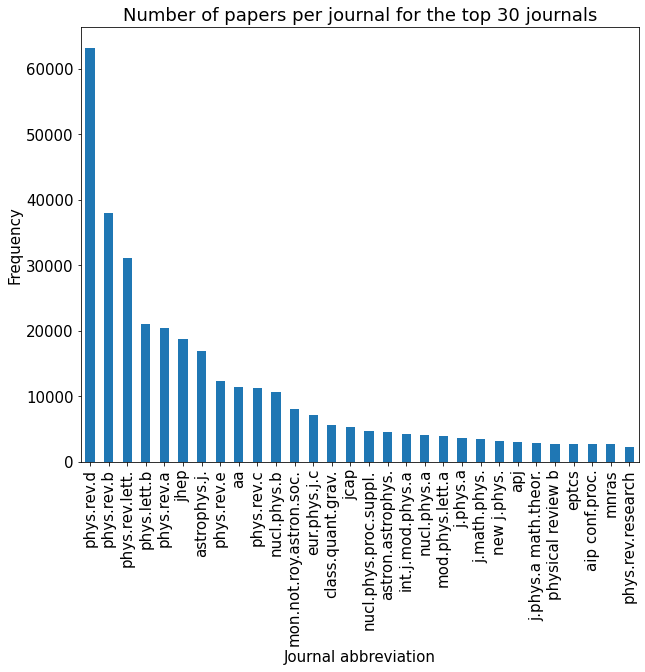

In [121]:
ax = journal_list.head(30).plot(kind="bar", 
        title="Number of papers per journal for the top 30 journals")
ax.set_xlabel("Journal abbreviation")
ax.set_ylabel("Frequency");

In [132]:
# join the counts of articles per journal to the main dataset
df = df.join(journal_list, on="journal_ref_root", lsuffix="", rsuffix="_freq")

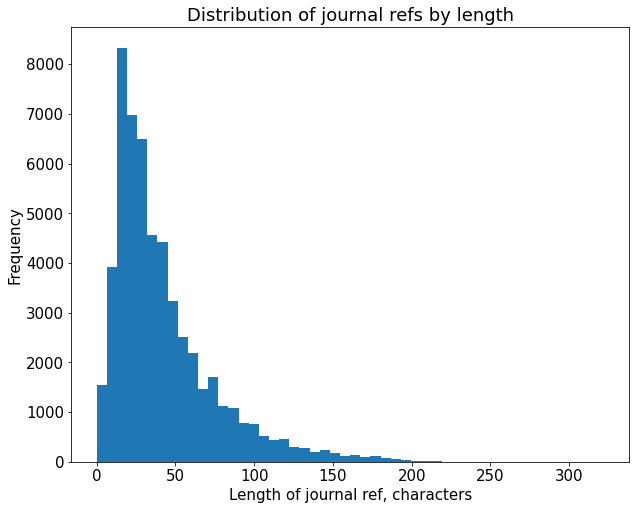

In [117]:
# examine cases where journal ref is extremely long
fig, ax = plt.subplots()
ax.set_title("Distribution of journal refs by length")
ax.set_xlabel("Length of journal ref, characters")
ax.set_ylabel("Frequency")

plt.hist([len(j) for j in journal_list.index], bins=50);

In [211]:
jref_long = []

for j in journal_list.index:
    
    if len(j) > 240:
        jref_long.append(j)
        
print(len(jref_long))
jref_long

2


['journal of data mining  digital humanities special issue on   computer-aided processing of intertextuality in ancient languages towards a   digital ecosystem nlp.corpus infrastructure.methods for retrieving texts   and computing text similarities march',
 'a version of this paper was published as p.yu.chebotarev   e.v.shamis.constructing an objective function for aggregating incomplete   preferences in a.tangian and j.gruber eds.econometric decision models   constructing scalar-valued objective functions.lecture notes in economics   and mathematical systems springer-verlag']

### Inspect the categories data for sensibleness

In [122]:
# construct a list of all categories, with counts
cat_list_flat = [cat for sub_list in df.category_list for cat in sub_list]
df_cats = pd.DataFrame(cat_list_flat, index=None, columns=["Category"])
cat_list_unique = df_cats.Category.value_counts()

print("Total number of categories used =", len(cat_list_flat))
print("Number of different categories =", len(cat_list_unique))

Total number of categories used = 1095401
Number of different categories = 176


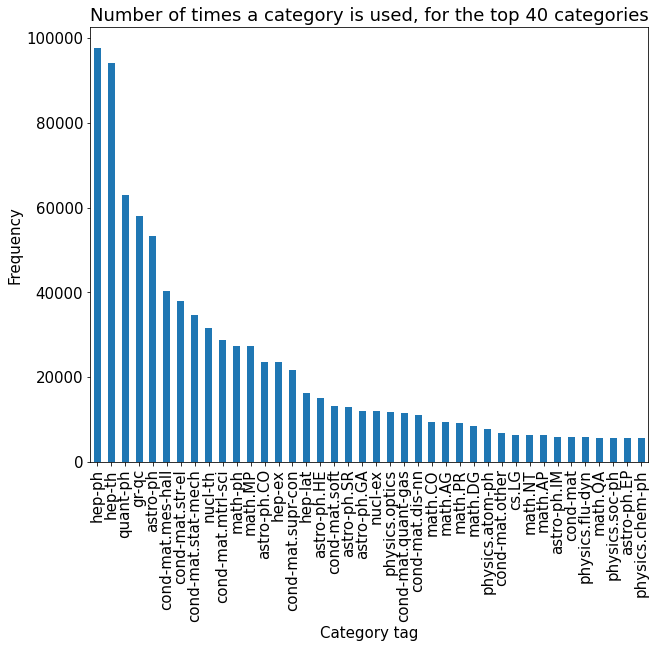

In [123]:
ax = cat_list_unique.head(40).plot(kind="bar", 
        title="Number of times a category is used, for the top 40 categories")
ax.set_xlabel("Category tag")
ax.set_ylabel("Frequency");

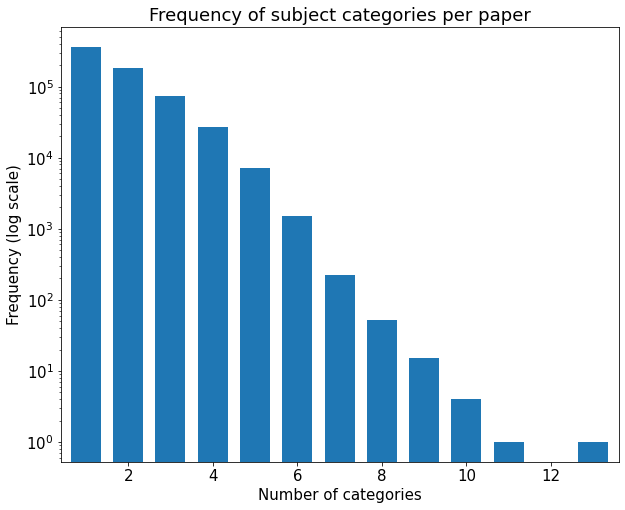

In [124]:
fig, ax = plt.subplots()
m, s, b = ax.stem(df.category_count.value_counts().index, 
                  df.category_count.value_counts(), 
                  markerfmt=" ", basefmt=" ")
ax.set(title="Frequency of subject categories per paper",
       yscale="log",
       xlabel="Number of categories", 
       ylabel="Frequency (log scale)")
plt.setp(s, linewidth=30);

In [210]:
# check that high category counts are not indicative of input data errors
df[df.category_count > 10]

,ID,Title,Comments,Journal,Categories,title_words,journal_ref_root,category_list,category_count,tword_count,journal_ref_root_freq
26528,804.1086,Visco-potential free-surface flows and long wa...,"29 pages, 13 figures. Some figures were update...",European Journal of Mechanics - B/Fluids (2009...,physics.flu-dyn math-ph math.AP math.MP math.N...,"[viscopotential, freesurface, flows, long, wav...",european journal of mechanics - bfluids,"[physics.flu-dyn, math-ph, math.AP, math.MP, m...",11,6,4
35677,808.1417,The finite harmonic oscillator and its associa...,Published in the Proceedings of the National A...,"PNAS, July 22, 2008 vol. 105 no. 29 9869-9873 ...",cs.IT cs.CR cs.DM math-ph math.GR math.IT math...,"[finite, harmonic, oscillator, associated, seq...",pnas july,"[cs.IT, cs.CR, cs.DM, math-ph, math.GR, math.I...",13,5,7


### Inspect the title words data for sensibleness

In [133]:
# construct a list of all title words, with counts
word_list_flat = [word for sub_list in df.title_words for word in sub_list]
df_words = pd.DataFrame(word_list_flat, index=None, columns=["Word"])
word_list_unique = df_words.Word.value_counts()

print("Total number of words used =", len(word_list_flat))
print("Number of different words =", len(word_list_unique))

Total number of words used = 4557038
Number of different words = 134909


In [209]:
a = df[df.tword_count == min(df.tword_count)]
print(len(a))
a.head(5)

16


,ID,Title,Comments,Journal,Categories,title_words,journal_ref_root,category_list,category_count,tword_count,journal_ref_root_freq
25438,803.3218,M2 to D2,"1+16 pages, LaTeX; v2: calculation unchanged, ...","JHEP 0805:085,2008",hep-th,[],jhep,[hep-th],1,0,18733
27659,804.3629,M5 from M2,"15 pages, minor modification","JHEP 0806:105,2008",hep-th,[],jhep,[hep-th],1,0,18733
31227,806.1639,D2 to D2,"1+11 pages, Latex; v2: section 3 revised and r...","JHEP 0807:041,2008",hep-th,[],jhep,[hep-th],1,0,18733
33401,807.1444,From N M2's to N D2's,"11 pages, 1 printable figure, close to the ver...","Phys.Rev.D78:125007,2008",hep-th,[],phys.rev.d,[hep-th],1,0,63236
58140,906.0965,27/32,"3 pages. v2: references added, minor typos cor...","Phys.Rev.Lett.103:061601,2009",hep-th,[],phys.rev.lett.,[hep-th],1,0,31084


In [156]:
a = df[df.tword_count == max(df.tword_count)]
print("".join(a.Title))
print(str(max(df.tword_count)) + " words")

New ultracool subdwarfs identified in large-scale surveys using Virtual   Observatory tools: II. SDSS DR7 vs UKIDSS LAS DR6, SDSS DR7 vs UKIDSS LAS   DR8, SDSS DR9 vs UKIDSS LAS DR10, and SDSS DR7 vs 2MASS
33 words


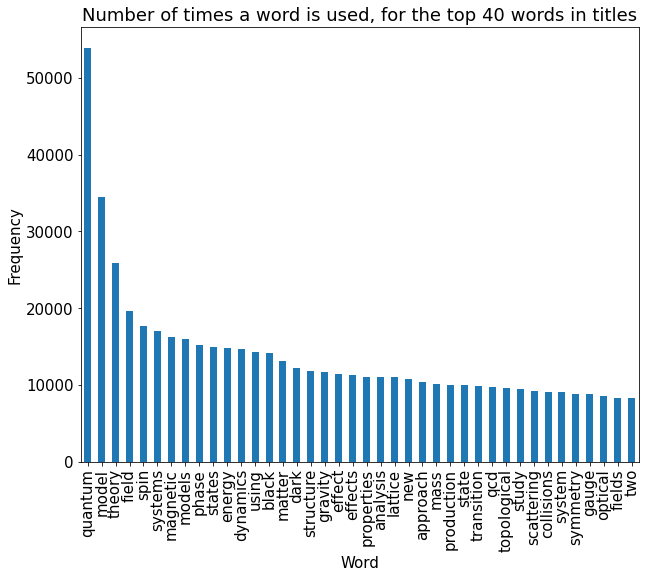

In [157]:
ax = word_list_unique.head(40).plot(kind="bar", 
        title="Number of times a word is used, for the top 40 words in titles")
ax.set_xlabel("Word")
ax.set_ylabel("Frequency");

### Report if there is a relation between journal ref and categories

In [158]:
# to examine journals vs cats, concentrate on only the most-used journals
df2 = df[df.journal_ref_root_freq > 200]

In [159]:
j_list = []
c_list = []

# tabulate the number of papers for each combination of journal and category
for j in df2.index:
    
    for c in df2.category_list[j]:
        j_list.append(df2.journal_ref_root[j])
        c_list.append(c)

j_c_xtab = pd.crosstab(np.array(j_list), np.array(c_list), 
                rownames=["Journal"], colnames=["Category"], dropna=False)
j_c_xtab

Category,acc-phys,adap-org,alg-geom,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
Journal,,,,,,,,,,,,,,,,,,,,,
aa,0,0,0,248,1359,1875,4495,1857,947,4613,...,0,0,0,12,3,3,3,0,2,0
acs nano,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
acta phys.polon.b,0,0,0,56,8,1,0,3,3,3,...,0,18,1,0,0,0,0,0,0,0
adv.math.,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
adv.theor.math.phys.,0,0,2,5,0,0,0,0,0,0,...,0,11,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
symmetry,0,0,0,0,28,2,3,17,2,0,...,0,61,0,0,0,0,0,0,1,0
theor.math.phys.,0,0,1,7,4,0,0,1,0,1,...,0,17,5,0,0,0,0,0,0,0
trans.amer.math.soc.,0,0,3,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,1,0


In [199]:
# add in the result of looking up the full journal name for each journal ref
j_c_xtab["full_journal_name"] = [decode_journal_ref(j) for j in j_c_xtab.index]
# this exposes some variant journal refs as repeats of the same journal; combine such rows
j_c_xtab2 = j_c_xtab.groupby(j_c_xtab.full_journal_name).sum()
j_c_xtab2

Category,acc-phys,adap-org,alg-geom,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
ABC News Now: Popcorn with Joel Siegel,0,0,0,5,39,8,72,45,53,64,...,0,0,0,0,0,1,0,0,0,0
ACS nano,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
AIP conference proceedings,2,0,0,652,142,4,38,117,35,72,...,0,121,0,1,0,2,0,1,2,0
"Acta chemica Scandinavica. Series A, Physical and inorganic chemistry",0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,2
Acta physica Polonica. B,0,0,0,56,8,1,0,3,3,3,...,0,18,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
prog theor exp phys,0,0,0,0,9,0,0,3,0,0,...,0,8,0,0,0,0,0,0,0,0
prog.theor.exp.phys.,0,0,0,0,15,0,2,18,3,1,...,0,24,0,0,0,0,1,0,0,0
prx quantum,0,0,0,0,0,0,0,0,0,0,...,0,230,0,0,0,0,6,0,0,0
science advances,0,0,0,0,0,9,2,2,0,8,...,0,64,0,1,0,0,3,0,0,0


In [200]:
# create a long & thin version of the tabulation, omitting combinations with 0 frequency
a = j_c_xtab2.reset_index().rename(columns={"index": "full_journal_name"})
j_c_melt = a.melt(id_vars="full_journal_name", value_vars=j_c_xtab2.columns, value_name="Frequency")
j_c_melt = j_c_melt[j_c_melt.Frequency > 0]
j_c_melt

,full_journal_name,Category,Frequency
2,AIP conference proceedings,acc-phys,2
43,Computer physics communications,acc-phys,1
120,"Nuclear physics. B, Proceedings, supplements",acc-phys,4
131,Physical review letters,acc-phys,1
137,"Physical review. E, Statistical, nonlinear an...",acc-phys,3
...,...,...,...
35627,Physical review letters,supr-con,7
35629,"Physical review. B, Condensed matter",supr-con,28
35631,Physical review. D,supr-con,1
35668,[Proceedings of the],supr-con,1


In [201]:
max(j_c_melt.Frequency)

33136

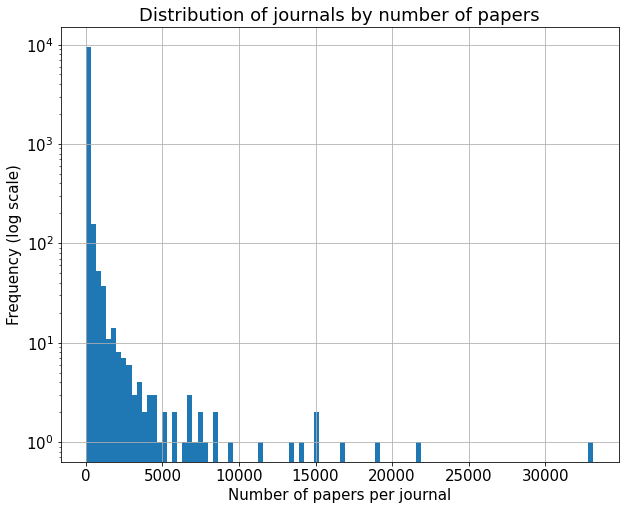

In [179]:
fig, ax = plt.subplots()

ax = j_c_melt.Frequency.hist(ax=ax, log=True, bins=100)
plt.title("Distribution of journals by number of papers")
ax.set_xlabel("Number of papers per journal")
ax.set_ylabel("Frequency (log scale)");

In [180]:
# create data to draw a graph
H = nx.Graph()
# nodes will be journals and categories
H.add_nodes_from(j_c_xtab2.index, color="red")
H.add_nodes_from(j_c_xtab2.columns, color="blue")
# edges will be non-zero frequencies of papers which feature journal/category pairings
H.add_edges_from(j_c_melt[["full_journal_name", "Category"]].apply(tuple, axis=1))

In [181]:
def generate_labels(graph, xtab, journal_threshold, category_threshold):
    """
    Creates three dicts, containing sets of...
    > labels (just sequential numbers)
    > legend entries (matching label numbers to journal names)
    > positions at which each label should be drawn
    Labels are only assigned if a journal / category is connected to a number
    of papers surpassing a specified threshold. Pass either journal_threshold or 
    category_threshold=None to supress labelling of journals and/or categories
    respectively.
    """
    
    labels = {}
    legend = {}
    positions = {}
    label_num = 0

    if journal_threshold is not None:
        
        for j in xtab[xtab.sum(axis=1) > journal_threshold].index:
            label_num += 1
            labels[j] = label_num
            legend[label_num] = j[:30]

    if category_threshold is not None:
        
        for c in xtab.columns[xtab.sum(axis=0) > category_threshold]:
            label_num += 1
            labels[c] = label_num
            legend[label_num] = c[:30]

    for node, pos in nx.circular_layout(graph).items():

        if node in labels:
            positions[node] = pos * 1.05

    return labels, legend, positions

In [183]:
def draw_journal_category_graph(graph, edge_widths, labels, graph_title):
    """
    Draws a graph of connections between journals and categories.
    labels is a tuple of a list of label texts and a list of label positions
    """
    fig, ax = plt.subplots()
    
    nx.draw_circular(graph, node_size=20, width=edge_widths, alpha=0.5, 
                 node_color=[g[1]["color"] for g in graph.nodes(data=True)])
    nx.draw_networkx_labels(graph, labels=labels[0], pos=labels[2], 
                        font_size=12, alpha=0.5, horizontalalignment="center");
    
    ax.set_title(graph_title)
    # use a text box to contain a label legend, in upper right corner
    legend_style = dict(boxstyle="square", facecolor="wheat", alpha=0.5)
    legend_text = ("Red points are journals\n" + "Blue points are categories\n\n" + 
                   "\n".join([str(key) + ": " + labels[1][key] for key in labels[1]]))
    ax.text(1.05, 0.95, legend_text, transform=ax.transAxes, fontsize=12,
            verticalalignment="top", bbox=legend_style)
    
    return True

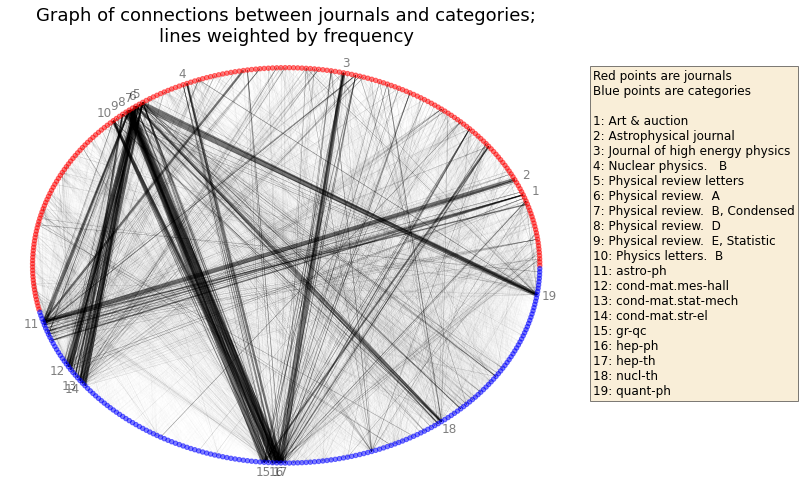

In [184]:
title = ("Graph of connections between journals and categories;\n" + 
         "lines weighted by frequency")
edge_widths = j_c_melt.sort_values(by=["full_journal_name", "Category"]).Frequency
draw_journal_category_graph(H, edge_widths * 10 / max(j_c_melt.Frequency), 
                            generate_labels(H, j_c_xtab2, 15000, 25000), title);

In [186]:
dist_j_by_c = j_c_xtab2.copy()

# divide each column (category) in turn by the vector of row totals
# this gives the distribution of each journal's articles by category
for b in j_c_xtab2.columns:
    dist_j_by_c[b] = j_c_xtab2[b] / j_c_xtab2.sum(axis=1)
    
a = dist_j_by_c.reset_index().rename(columns={"index": "full_journal_name"})
j_c_melt2 = a.melt(id_vars="full_journal_name", 
                   value_vars=dist_j_by_c.columns, value_name="Frequency")
j_c_melt2 = j_c_melt2[j_c_melt2.Frequency > 0]

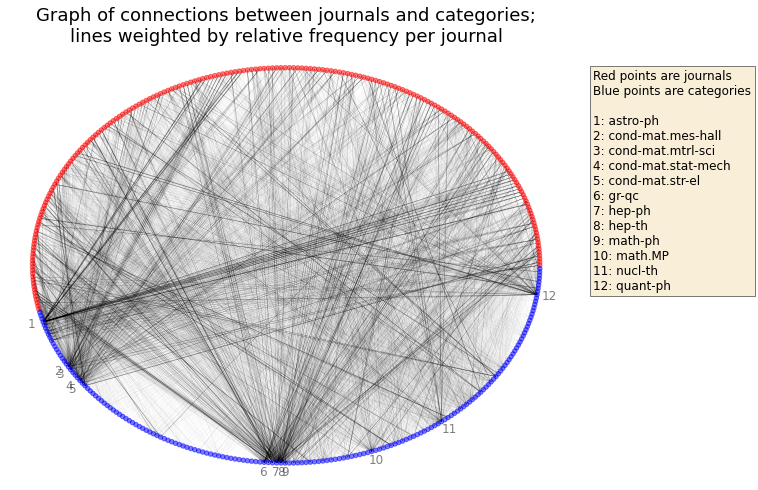

In [187]:
# line strengths represent the distribution of each journal's articles by category

title = ("Graph of connections between journals and categories;\n" + 
         "lines weighted by relative frequency per journal")
edge_widths = j_c_melt2.sort_values(by=["full_journal_name", "Category"]).Frequency
draw_journal_category_graph(H, edge_widths, generate_labels(H, dist_j_by_c, None, 5), title);

In [188]:
dist_c_by_j = j_c_xtab2.copy()

# divide each row (journal) in turn by the vector of column totals
# this gives the distribution of articles in each category by journal
for b in j_c_xtab2.index:
    dist_c_by_j[dist_c_by_j.index == b] = j_c_xtab2[j_c_xtab2.index == b] / j_c_xtab2.sum(axis=0)

a = dist_c_by_j.reset_index().rename(columns={"index": "full_journal_name"})
j_c_melt3 = a.melt(id_vars="full_journal_name", 
                   value_vars=dist_c_by_j.columns, value_name="Frequency")
j_c_melt3 = j_c_melt3[j_c_melt3.Frequency > 0]

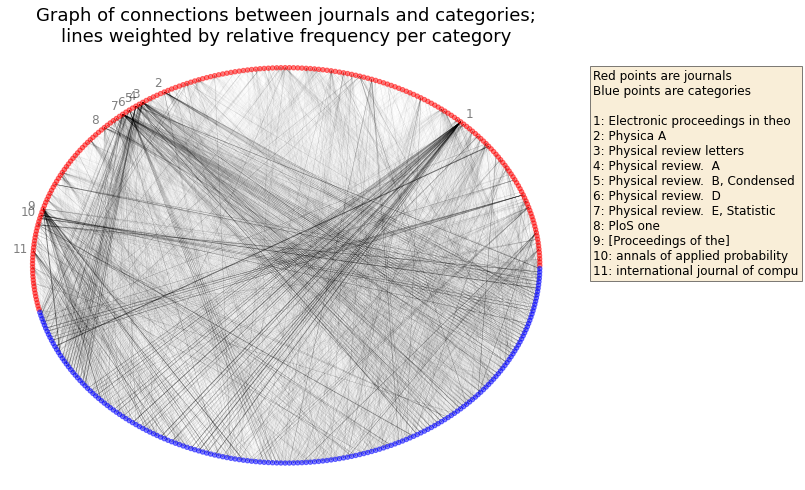

In [189]:
# line strengths represent the distribution of articles in each category by journal

title = ("Graph of connections between journals and categories;\n" + 
         "lines weighted by relative frequency per category")
edge_widths = j_c_melt3.sort_values(by=["full_journal_name", "Category"]).Frequency
draw_journal_category_graph(H, edge_widths, generate_labels(H, dist_c_by_j, 2.5, None), title);

### Pick the top ten words in titles, and recommend a journal for each word

In [190]:
# find the most-used words in article titles

# construct a list of all title words, with counts
word_list_flat = [word for sub_list in df.title_words for word in sub_list]
df_words = pd.DataFrame(word_list_flat, index=None, columns=["Word"])
word_list_unique = df_words.Word.value_counts()
top_10_words = word_list_unique.head(10)

print("Total number of words used =", len(word_list_flat))
print("Number of different words =", len(word_list_unique))

Total number of words used = 4557038
Number of different words = 134909


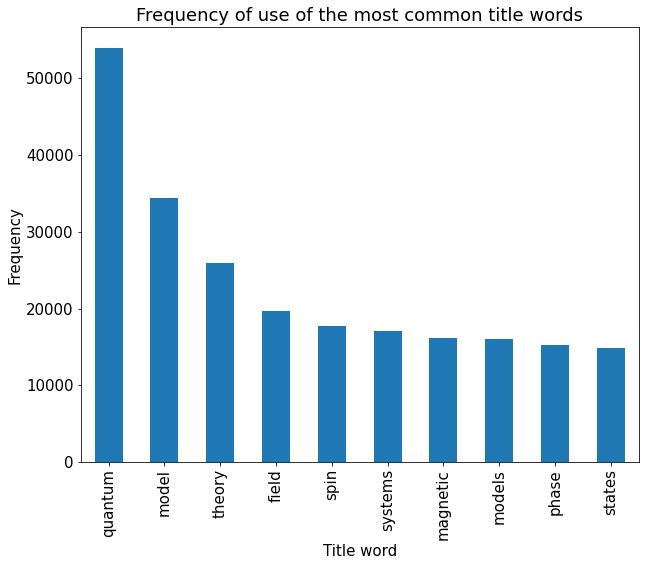

In [191]:
ax = top_10_words.plot(kind="bar", title="Frequency of use of the most common title words")
ax.set_xlabel("Title word")
ax.set_ylabel("Frequency");

In [198]:
j_list = []
w_list = []

# tabulate the number of papers for each combination of title word and journal
for a in df.index:
    
    for w in df.title_words[a]:
        
        if w in top_10_words:
            j_list.append(df.journal_ref_root[a])
            w_list.append(w)

j_w_xtab = pd.crosstab(np.array(j_list), np.array(w_list),
                       rownames=["Journal"], colnames=["Word"], dropna=False)

In [202]:
def top_10_recommendations(top_words, j_w_freqs):
    """ Given a dataframe of 'top' words and their frequency in the whole dataset, 
    and a dataframe of frequencies of papers by journal and title word, returns a 
    list of the journals which have the most papers featuring each of the top words.
    Also works if the 'frequencies' in the table are in fact distributions.
    """
    
    top_recs = []

    for w in top_words.index:
        most_hits = j_w_freqs[j_w_freqs[w] == max(j_w_freqs[w])][w]
        top_recs.append([w, most_hits.values[0], 
                         top_10_words[top_words.index == w].values[0],
                         decode_journal_ref(most_hits.index[0])])
        
    return top_recs

In [203]:
top_10_recommendations(top_10_words, j_w_xtab)

[['quantum', 6533, 53976, 'Physical review.  B, Condensed matter'],
 ['model', 4592, 34470, 'Physical review.  D'],
 ['theory', 3437, 25909, 'Physical review.  D'],
 ['field', 2655, 19627, 'Physical review.  D'],
 ['spin', 4843, 17682, 'Physical review.  B, Condensed matter'],
 ['systems', 1711, 17079, 'Physical review.  B, Condensed matter'],
 ['magnetic', 3436, 16200, 'Physical review.  B, Condensed matter'],
 ['models', 2161, 15984, 'Physical review.  D'],
 ['phase', 2484, 15264, 'Physical review.  B, Condensed matter'],
 ['states', 2227, 14908, 'Physical review.  B, Condensed matter']]

In [196]:
j_list = []
w_list = []

for a in df2.index:
    
    for w in df2.title_words[a]:
        
        if w in top_10_words:
            j_list.append(df2.journal_ref_root[a])
            w_list.append(w)

j_w_xtab3 = pd.crosstab(np.array(j_list), np.array(w_list),
                       rownames=["Journal"], colnames=["Word"], dropna=False)

j_w_xtab3 = j_w_xtab3.join(df2[["journal_ref_root", "tword_count"]].groupby("journal_ref_root").sum())

for w in top_10_words.index:
    j_w_xtab3[w] = j_w_xtab3[w] / j_w_xtab3.tword_count

In [206]:
top_10_recommendations(top_10_words, j_w_xtab3)

[['quantum', 0.10601548540798095, 53976, 'prx quantum'],
 ['model', 0.023031688990525972, 34470, 'Physica A'],
 ['theory',
  0.027777777777777776,
  25909,
  "NASA's Physical Sciences Research Program annual report"],
 ['field', 0.022339027595269383, 19627, 'Reviews in mathematical physics'],
 ['spin',
  0.017064846416382253,
  17682,
  'Chekhoslovat︠s︡kiĭ fizicheskiĭ zhurnal. Czechoslovak journal of physics'],
 ['systems',
  0.015255432344080508,
  17079,
  'Electronic proceedings in theoretical computer science'],
 ['magnetic', 0.018102824040550327, 16200, 'Astronomische Nachrichten'],
 ['models', 0.02219526986052153, 15984, 'annals of statistics'],
 ['phase', 0.011660188784008884, 15264, 'j.phys.soc.jpn.vol.'],
 ['states', 0.017482517482517484, 14908, 'Quantum information processing']]